## Computational Homework 6

## Part 1: Cross Validation

In this part, we will explore a technique called _cross-validation_ that can be used to estimate the regularization parameter $\lambda$ in techniques like Ridge regression and LASSO. 

For this, we will need to download the file `EGFR_bioactivity.pkl` from [this link](https://drive.google.com/drive/folders/1OkXMcFo0urN0kSQYH4d75I4V3pnSpV6H?usp=sharing).

Once downloaded (and saved in the same directory as this notebook), the file can be loaded using the following.

In [1]:
import pickle 

with open('EGFR_bioactivity.pkl', 'rb') as f:
    data = pickle.load(f)
    
X = data["X"]
y = data["y"]
X.shape, y.shape

((2000, 512), (2000,))

The `EGFR_bioactivity` dataset contains bioactivity data for $n = 2000$ different drugs, each represented by a molecular "fingerprints", which here is a binary vector of length $p = 256$ indicating in each dimension whether the molecule contains a particular substructure or not. The response `y` is a measurement of how active each drug is against a particular protein (called EGFR) that it is targeting. The goal with this dataset is to build a model to predict this bioactivity from the features of the molecules.

To do this, we will try fitting a Ridge regression model, as discussed in lab. As we've seen, fitting a Ridge regression model requires choosing a regularization parameter $\lambda$, which we will do using a technique called cross-validation. The core idea with cross-validation is that we should pick the value of $\lambda$ that achieves the smallest error rate on a held-out set of data not present in the data used to fit the model.

Generically, ($k$-fold) cross-validation works as follows: 

- Fix an integer $0<k\leq n$, and split the dataset into $k$ non-overlapping, equally sized groups $S_1,\dots,S_k$.
- Loop through each of the $k$ groups. At step $j$, fit the model on all of the data _except_ those datapoint in group $j$ to obtain parameters $\hat{\beta}_{(-j)}(\lambda)$. Then, use this model to make predictions on the $j$th group of data: $\hat{y}^{(-j)}_i = x_i\cdot \hat{\beta}_{(-j)}(\lambda)$ for $i \in S_j$ (i.e. the points that weren't in the data used for fitting the model). Calculate the MSE of these predictions $\text{MSE}_{j}(\lambda) = \sum_{i \in S_j} (\hat{y}_i^{(-j)} - y_i)^2$.
- After fitting and evaluating models on all $k$ subsets, compute the mean error across each of the $k$ subsets: $\text{MSE}(\lambda) = \frac{1}{k}\sum_{j=1}^k \text{MSE}_j(\lambda)$. This is called the _cross-validation error_.

To perform the splitting of the data, we can use the following function (most of the work here is being done by the function `np.array_split`).

In [2]:
import numpy as np

def k_fold_split(n=1000, k=5):
    ix = range(n)
    test_ix = np.array_split(ix, k)
    train_ix = [[j for j in ix if j not in tix] for tix in test_ix]
    return train_ix, test_ix

Below is an example of how we could use this function.

In [3]:
k = 5
train_ix, test_ix = k_fold_split(n = X.shape[0], k=k)

for tr_ix, te_ix in zip(train_ix, test_ix):
    X_train_curr, X_test_curr = X[tr_ix], X[te_ix]
    y_train_curr, y_test_curr = y[tr_ix], y[te_ix]
    print(y_train_curr.shape, y_test_curr.shape)

(1600,) (400,)
(1600,) (400,)
(1600,) (400,)
(1600,) (400,)
(1600,) (400,)


Here, we set $k=5$, and looped through each of the folds, generating a training and testing set at each step, which is what we need to be able to do the $k$-fold cross validation strategy above.

**Problem 1.** Use $5$-fold cross validation to estimate the cross validation error for a Ridge regression model fit with a fixed regularization parameter $\lambda = 5$. (See the [online book](https://rythei.github.io/linear-models/content/generalizing_linear_regression/ridge_and_lasso.html) for example of how to fit such a model.) 

In [4]:
def fit_ridge(X, y, lamb=5):
    return np.linalg.inv(X.T@X+lamb*np.eye(X.shape[1]))@X.T@y


def ridge_cv(X, y, k=5, lamb=5):
    train_ix, test_ix = k_fold_split(n = X.shape[0], k=k)

    mses_RR = []

    for tr_ix, te_ix in zip(train_ix, test_ix):
        X_train_curr, X_test_curr = X[tr_ix], X[te_ix]
        y_train_curr, y_test_curr = y[tr_ix], y[te_ix]
        beta_hat = fit_ridge(X_train_curr, y_train_curr, lamb=lamb)
        y_hat_curr = np.dot(X_test_curr, beta_hat)
        mse_curr = np.mean((y_test_curr-y_hat_curr)**2)
        mses_RR.append(mse_curr)

    return np.mean(mses_RR)

ridge_cv(X, y, k=5, lamb=5)

1.4517855370370727

**Problem 2.** Now that we've developed a method to estimate the cross-validation error for a model with a fixed $\lambda$, do the following: repeat the steps in problem 1 for a grid of $\lambda$ values (for this problem a good range might be `np.exp(np.linspace(-3,7,10))`), and for each use 5-fold cross validation to estimate the cross-validation error. Plot these errors as a function of $\lambda$, and report the value of $\lambda$ that has the smallest error. (Note since we are using a log scale, the plot might look nicer if you use the option `plt.xscale("log")`).


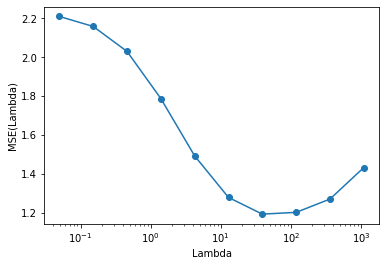

In [5]:
import matplotlib.pyplot as plt

lamb_range = np.exp(np.linspace(-3,7,10))

mses = []
for lamb in lamb_range:
    mses.append(ridge_cv(X, y, lamb=lamb))
    
plt.plot(lamb_range, mses, marker='o')
plt.xlabel("Lambda")
plt.ylabel("MSE(Lambda)")
plt.xscale("log")
plt.show()

## Part 2: LASSO for variable selection

In this problem, we will investigate using LASSO regression to perform variable selection, i.e. to automatically select a subset of the most important features. To fit LASSO models, you can use the `sklearn` package in python (see the [online book](https://rythei.github.io/linear-models/content/generalizing_linear_regression/ridge_and_lasso.html) for examples of how to do this).

For this problem, we'll work with the California housing dataset, in which the goal is to predict the median house value in given region of California using various features. Once downloaded, the data can be loaded and processed using the following.

In [19]:
import pandas as pd 
dataset = pd.read_csv("california_housing.csv")
y = dataset["MedHouseVal"].to_numpy()
feature_cols = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude"]
X = dataset[feature_cols].to_numpy()
ones = np.ones(shape=(X.shape[0], 1))
feature_cols = ["Intercept"] + feature_cols
X = np.hstack([ones, X])

**Problem 3.** Using a range of $\lambda$ values (say `np.exp(np.linspace(-4, 1, 5))`), compute the LASSO solution for this dataset, and for each value of $\lambda$ report which coefficients are non-zero (and what features they are associated with). How many features are kept for the largest value of $\lambda$? Which features are these? If you had to use this method, what would you say are the three most "important" features?

In [20]:
from sklearn.linear_model import Lasso

feature_cols = np.array(feature_cols)
features = []
for lamb in np.exp(np.linspace(-4,1,5)):
    beta_hat = Lasso(lamb).fit(X, y).coef_
    nonzero_ix = np.argwhere(beta_hat != 0).flatten()
    features.append(feature_cols[nonzero_ix])
    
features

[array(['MedInc', 'HouseAge', 'AveBedrms', 'Population', 'AveOccup',
        'Latitude', 'Longitude'], dtype='<U10'),
 array(['MedInc', 'HouseAge', 'Population', 'AveOccup', 'Latitude',
        'Longitude'], dtype='<U10'),
 array(['MedInc', 'HouseAge', 'Population', 'AveOccup', 'Latitude'],
       dtype='<U10'),
 array(['MedInc', 'HouseAge', 'Population'], dtype='<U10'),
 array(['Population'], dtype='<U10')]

**Problem 4.** Similar to problem 2, use 5-fold cross-validation to select the best value of $\lambda$ for the LASSO model, and plot the cross-validation errors as a function of $\lambda$. What value of $\lambda$ do you pick? Which features are selected (i.e. have non-zero coefficients) at this value of $\lambda$?

In [21]:
def lasso_cv(X, y, k=5, lamb=1):
    train_ix, test_ix = k_fold_split(n = X.shape[0], k=k)

    mses_lasso = []

    for tr_ix, te_ix in zip(train_ix, test_ix):
        X_train_curr, X_test_curr = X[tr_ix], X[te_ix]
        y_train_curr, y_test_curr = y[tr_ix], y[te_ix]
        beta_hat = Lasso(lamb).fit(X, y).coef_
        y_hat_curr = np.dot(X_test_curr, beta_hat)
        mse_curr = np.mean((y_test_curr-y_hat_curr)**2)
        mses_lasso.append(mse_curr)

    return np.mean(mses_lasso)

best lambda: 0.2290799498154876


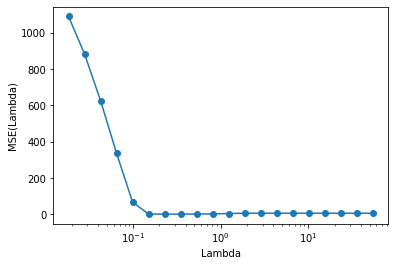

In [22]:
lamb_range = np.exp(np.linspace(-4,4,20))

mses = []
for lamb in lamb_range:
    mses.append(lasso_cv(X, y, lamb=lamb))
    
best_ix = np.argmin(mses)
lamb_best = lamb_range[best_ix]
print(f"best lambda: {lamb_best}")
plt.plot(lamb_range, mses, marker='o')
plt.xlabel("Lambda")
plt.ylabel("MSE(Lambda)")
plt.xscale("log")
plt.show()

In [23]:
beta_hat_best = Lasso(lamb_best).fit(X, y).coef_
nonzero_ix = np.argwhere(beta_hat != 0).flatten()
features = feature_cols[nonzero_ix]
features #only population!

array(['Population'], dtype='<U10')